# Advanced Lane Finding Project

The goals / steps of this project are the following:

* 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* 2. Apply a distortion correction to raw images.
* 3. Use color transforms, gradients, etc., to create a thresholded binary image.
* 4. Apply a perspective transform to rectify binary image ("birds-eye view").
* 5. Detect lane pixels and fit to find the lane boundary.
* 6. Determine the curvature of the lane and vehicle position with respect to center.
* 7. Warp the detected lane boundaries back onto the original image.
* 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1. Camera calibration using chessboard images

The calibration images in the lesson exercise were taken with a different camera setting and a different chessboard pattern than the calibration images for the project. You need to set your chessboard size to 9x6 for the project instead of 8x6 as in the lesson.

In [1]:
# 1 
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
%matplotlib qt

In [2]:
# 2 
# refactor codes in https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb
def calibrate_camera(images):
    # prepare object points
    nx = 9#TODO: enter the number of inside corners in x
    ny = 6#TODO: enter the number of inside corners in y

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        img_size = (img.shape[1], img.shape[0])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    # https://docs.opencv.org/2.4.1/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    return mtx, dist

In [3]:
# 3
# Make a list of calibration images
camera_cal_images = glob.glob('camera_cal/calibration*.jpg')

cam_mtx, cam_dist = calibrate_camera(camera_cal_images)

## 2. Apply a distortion correction to raw images.

After calibrating the camera, one `cv2.undistort()` can be used to correct the image distortion as below:

In [4]:
# 4
'''
Inputs: path of the camera image, cameraMatrix and distCoeffs from calibrate_camera()
Outputs: return undistorted image and fill the array of undistorted images: undist_images
'''
undist_images = []

def undistort_image(img, cam_mtx, cam_dist):
    undist = cv2.undistort(img, cam_mtx, cam_dist, None, cam_mtx)
    return undist
    
def compare_images(orig_img, output_img, output_img_caption): 
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.imshow(orig_img)
    plt.xlabel('Original image')
    plt.subplot(1, 2, 2)
    plt.imshow(output_img)
    plt.xlabel(output_img_caption)
    plt.show()
    
# img_urls = glob.glob('test_images/test*.jpg')
def display_undistorted_images(img_urls, save=False):
    for img_url in img_urls:
        orig_img = mpimg.imread(img_url)
        img_filename = img_url.split("/")[1]
        print("Test distortion corrected image with %s" %img_filename)
        undist_img = undistort_image(orig_img, cam_mtx, cam_dist)
        if save:
            undist_images.append(undist_img)
        compare_images(orig_img, undist_img, 'Distortion corrected image')

Test distortion corrected image with calibration1.jpg


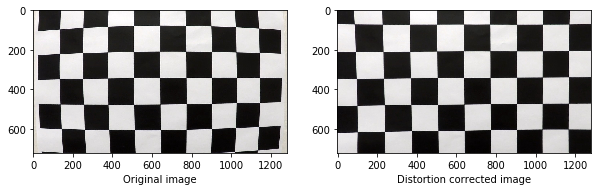

In [5]:
# 5
display_undistorted_images(glob.glob('camera_cal/calibration1.jpg'))

Test distortion corrected image with test5.jpg


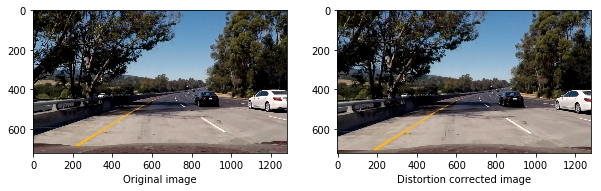

Test distortion corrected image with test4.jpg


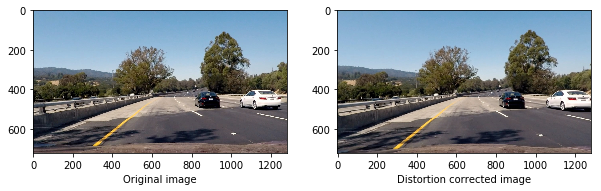

Test distortion corrected image with test2.jpg


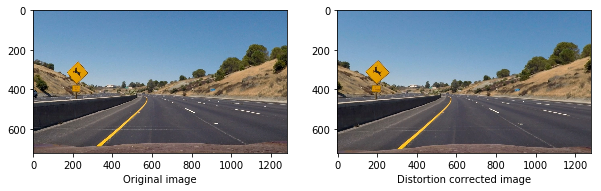

Test distortion corrected image with test1.jpg


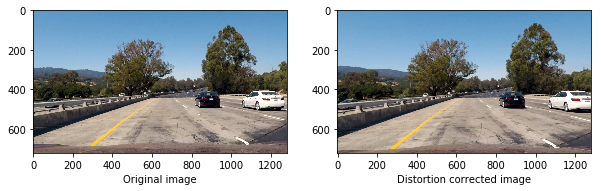

Test distortion corrected image with test6.jpg


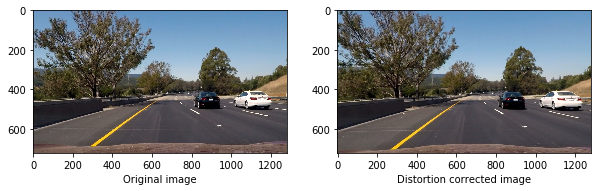

Test distortion corrected image with test3.jpg


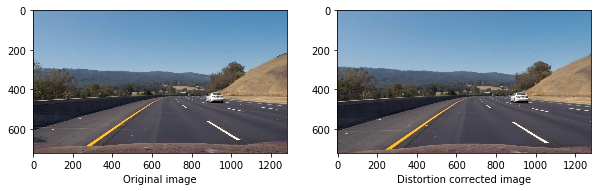

In [6]:
# 6
display_undistorted_images(glob.glob('test_images/test*.jpg'), save=True)

## 3. Detect Steep Edges using Gradiant and Color Thresholds

In the first project, the next step of the pipeline to process the images is to apply the Gaussian smoothing and find the parameters for Canny Edges. As the lectures addressed, we can use gradients in a smarter way to detect the steep edges belonging to the lanes we want the car to focus on.

To simplify the codes, I refactor the sobel implementations in the Lession 6, so the sobel-x, sobel-y, sobel magnitude, sobel direction functions are:


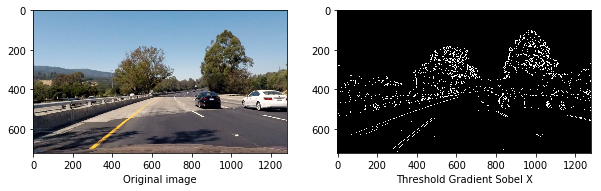

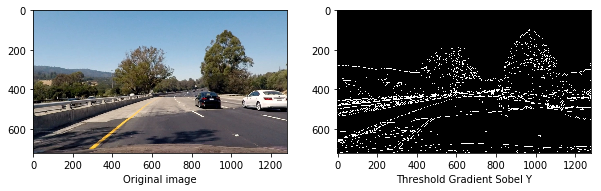

In [7]:
# 7
'''
absolute sobel value of x and y
'''
def abs_sobel_xy(img, sobel_kernel=3):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    return abs_sobel_x, abs_sobel_y

# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # 1) Take the derivative in x or y given orient = 'x' or 'y'
    abs_sobel_x, abs_sobel_y = abs_sobel_xy(img, sobel_kernel)
    if orient == 'x':
        abs_sobel = abs_sobel_x
    if orient == 'y':
        abs_sobel = abs_sobel_y
    # 2) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 3) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 4) Return this mask as your binary_output image
    return binary_output

# Plot function
def plot_thresh(orig_img, grad_binary, thresh_type):
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.imshow(orig_img)
    plt.xlabel('Original image')
    plt.subplot(1, 2, 2)
    plt.imshow(grad_binary, cmap='gray')
    plt.xlabel('Threshold Gradient '+thresh_type)
    plt.show()

# Run the function
color_image = np.copy(undist_images[1])

gradx = abs_sobel_thresh(color_image, orient='x', thresh=(30,100))
plot_thresh(color_image, gradx, 'Sobel X')

grady = abs_sobel_thresh(color_image, orient='y', thresh=(30,100))
plot_thresh(color_image, grady, 'Sobel Y')


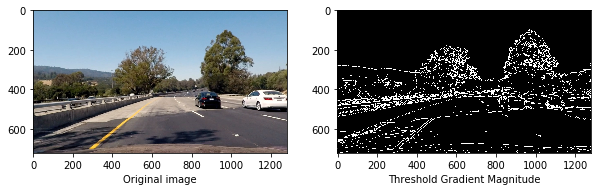

In [8]:
# 8
'''
Magnitude of the Gradient
'''
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # 1) Take the gradient in x and y separately
    abs_sobel_x, abs_sobel_y = abs_sobel_xy(img, sobel_kernel)
    # 2) Calculate the magnitude 
    abs_sobelxy = np.sqrt(abs_sobel_x**2 + abs_sobel_y**2)
    # 3) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 4) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

mag_binary = mag_thresh(color_image, thresh=(30, 100))
plot_thresh(color_image, mag_binary, 'Magnitude')


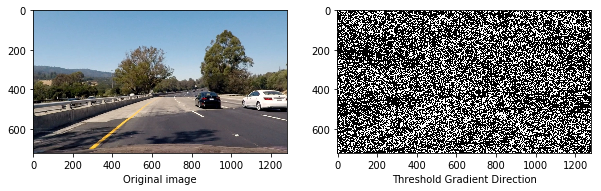

In [9]:
# 9
'''
Direction of the Gradient
'''
def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Take the gradient in x and y separately
    abs_sobel_x, abs_sobel_y = abs_sobel_xy(img, sobel_kernel)
    # 2) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobel_y, abs_sobel_x)
    # 3) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(direction)
    # 4) Return this mask as your binary_output image
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return binary_output

dir_binary = dir_thresh(color_image, thresh=(0.7, 1.3))
plot_thresh(color_image, dir_binary, 'Direction')


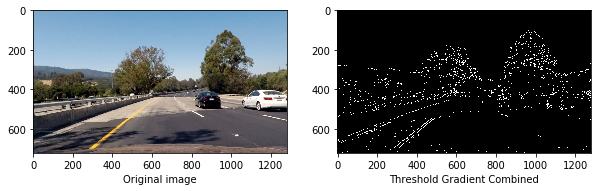

In [10]:
# 10
# combine thresholds above
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
plot_thresh(color_image, combined, 'Combined')


### HLS and Color Thresholds

So far, after applying the gradient threshold, the processed images in gray scale still look nosiy. Applying color threshold to the images could improve the robustness of the image processing so the lane lines would be more observable than using only the gradient thresholds.

I specifically elaborate this part because I spent tons of time to tune the parameters to get an "ideal" binary image, in which the lane lines can be clearly observed.

I refactor the HLS and color threshold in the forementioned lectures as the function below:


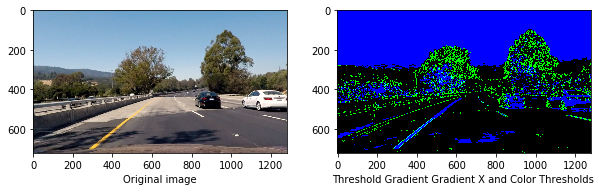

In [11]:
# 11
'''
Convert to HLS color space and separate the S channel
'''
def color_gradx_thresh(img, s_thresh=(100, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary

color_gradx_binary = color_gradx_thresh(color_image)
plot_thresh(color_image, color_gradx_binary, 'Gradient X and Color Thresholds ')


The processed image above right is the result of combining gradient x and color thresholds. Now let's see what will the output image look like when combining all the magnitude, direction and absolute value of the gradient, with the color threshold.


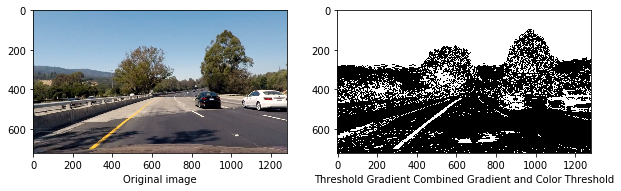

In [12]:
# 12
def color_gradient_thresh(img, s_thresh=(100, 255)):
    # gradient method
    gradx = abs_sobel_thresh(img, 'x', sobel_kernel=3, thresh=(20, 100))
    grady = abs_sobel_thresh(img, 'y', sobel_kernel=3, thresh=(20, 100))
    mag_binary = mag_thresh(img, thresh=(20, 100))
    dir_binary = dir_thresh(img, sobel_kernel=15, thresh=(0.7, 1.3))
    
    grad = np.zeros_like(gradx)
    grad[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    # Threshold color channel
    color_binary = color_gradx_thresh(img)
    binary_img = np.zeros_like(gradx)
    binary_img[(grad == 1) | (color_binary[:,:,2] == 255)] = 1
    return binary_img

color_grad_binary = color_gradient_thresh(color_image)
plot_thresh(color_image, color_grad_binary, 'Combined Gradient and Color Threshold')


In the output image on the above right figure, the lane lines are more observable than the results of only applying the gradient threshold. However, there are two concerns still:

1. The gray scale image looks still noisy 
2. The upper half of the image is all white, same color as the lane lines. 

The root cause of the 2nd issue is because the color threshold parameter used above could not deal well with the lightness but only with the saturation. In the output image of `color_gradx_thresh()` function, we can see that the lane line color shows the similar blue color as the sky. 
So we can tune the color threshold parameters to filter out the blue sky background and mark the lane line with a different color.

I find a nice threshold method combining HLS, LAB, LUV color thresholds. The reference article is posted at https://zhuanlan.zhihu.com/p/35134563 in Chinese. *My contributions* here include: 1) refactor the source codes into a neat function named `cvt_color_select()` after understanding the original idea; 2) tune in the color parameters for HLS, LUV, and LAB thresholds to achiever better results compared to the results with the original author.

Another solution is we can simply adjust the region of interest to force the pipeline to focus on the lower part of the image. I feel this solution is not very flexible and scalable with different image resolutions because it requires more parameters of the region of interest. 

In [13]:
# 13
'''
Reference: https://github.com/yang1688899/CarND-Advanced-Lane-Lines/blob/master/utils.py
I refactor the source codes as a concise function below
'''
def cvt_color_select(img, channel=2,thresh=(0, 255), thresh_type='hls'):
    cvt = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if thresh_type == 'luv':
        cvt = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif thresh_type == 'lab':
        cvt = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    else:
        pass
    selected_channel= cvt[:,:,channel]
    binary_output = np.zeros_like(selected_channel)
    binary_output[(selected_channel > thresh[0]) & (selected_channel <= thresh[1])] = 1
    return binary_output

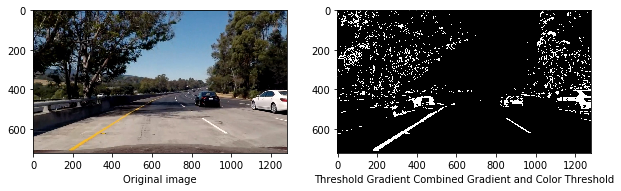

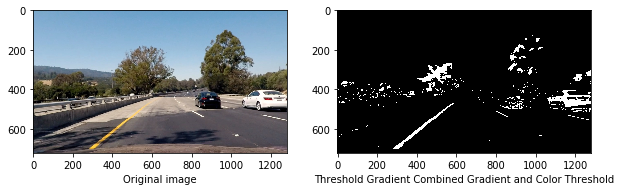

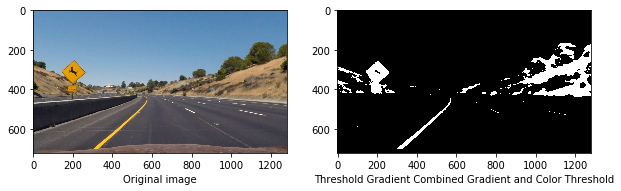

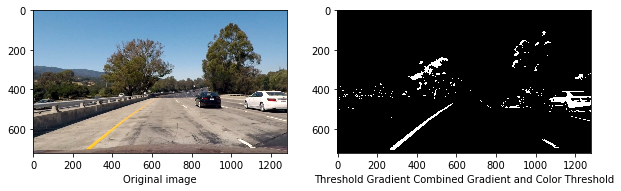

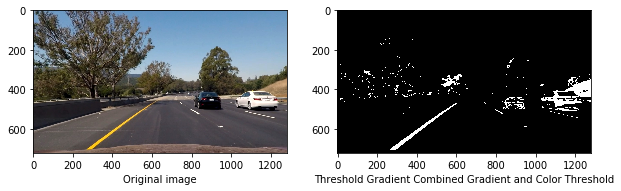

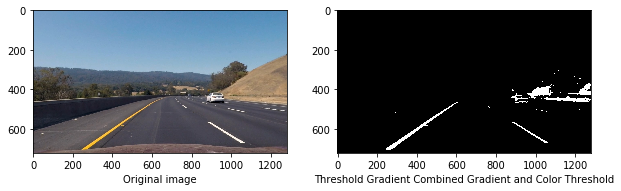

In [14]:
# 14
'''
Modified from the previous color_gradient_thresh function(), this function combines:
- sobel gradient
- magnitude of gradient
- direction of gradient
- lab selection on the Lightness channel
- luv selection on the Lightness channel
- hls selection on the Saturation channel
finally outputs a gray scale binary image focusing on the lane edges
Meanwhile, save the output binary images to a global array thresh_images
'''
thresh_images = []

def hls_gradient_thresh(img):
    # gradient method
    gradx = abs_sobel_thresh(img, 'x', sobel_kernel=3, thresh=(30, 150))
    grady = abs_sobel_thresh(img, 'y', sobel_kernel=3, thresh=(30, 150))
    mag_binary = mag_thresh(img, thresh=(30, 150))
    dir_binary = dir_thresh(img, sobel_kernel=15, thresh=(0.7, 1.3))
    grad = np.zeros_like(gradx)
    
    hls_thresh = cvt_color_select(img, channel=2, thresh=(200, 255))
    lab_thresh = cvt_color_select(img, channel=2, thresh=(150, 200), thresh_type='lab')
    luv_thresh = cvt_color_select(img, channel=0, thresh=(225, 255), thresh_type='luv')

    #Thresholding combination
    binary_img = np.zeros_like(gradx)
    binary_img[((dir_thresh==1) & (mag_thresh==1)) | (grad==1) | (hls_thresh==1) | (luv_thresh==1) | (lab_thresh==1)] = 1
    thresh_images.append(binary_img)
    return binary_img

img_urls = glob.glob('test_images/test*.jpg')
for img_url in img_urls:
    orig_img = mpimg.imread(img_url)
    img_filename = img_url.split("/")[1]
    undist_img = cv2.undistort(orig_img, cam_mtx, cam_dist, None, cam_mtx)
    color_grad_binary = hls_gradient_thresh(undist_img)
    plot_thresh(undist_img, color_grad_binary, 'Combined Gradient and Color Threshold')
   

## 4. Perspective Transform

Now apply perspective transform to the binary image to get a rectified binary image, so called "birds-eye view". Take the first undistorted color image as example. Below there are three figures: 
- the first figure draws a quadrilateral in the red color containing the region of interest, that is, the left and right lane lines;
- the second figure draws a warped image by applying the perspective transform in the specified region;
- the third figure draws the lane lines reverted from the second figure by applying the inversed transform matrix; Note, in the section 7, we will use this method to draw the detected lane boundaries back onto the original image in terms of the warped image.
 

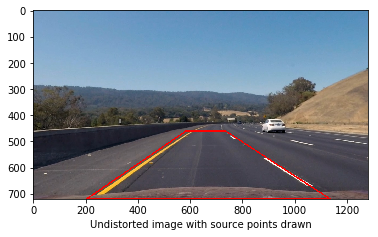

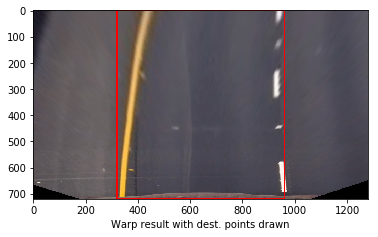

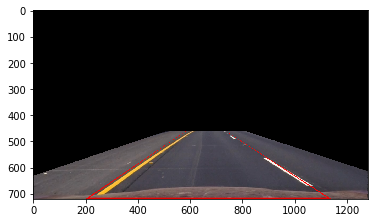

In [15]:
# 15
# define src and dst points
undist_color_img = np.copy(undist_images[5])
x_len, y_len = undist_color_img.shape[1], undist_color_img.shape[0]
img_size = (x_len, y_len)

src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 70, img_size[1]],
    [(img_size[0] / 2 + 95), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

src_lines = cv2.polylines(undist_color_img, np.int32([src]), True, (255,0,0), 3)
plt.imshow(src_lines)
plt.xlabel('Undistorted image with source points drawn')
plt.show()

M, Minv = cv2.getPerspectiveTransform(src, dst), cv2.getPerspectiveTransform(dst,src)

undist_color_img = np.copy(undist_images[5])
warp_box = cv2.warpPerspective(undist_color_img, M, (x_len, y_len), cv2.INTER_LINEAR)
warp_lines = cv2.polylines(warp_box, np.int32([dst]), True, (255,0,0), 3)
plt.imshow(warp_lines)
plt.xlabel('Warp result with dest. points drawn')
plt.show()

# Restore to original image
restore_img = cv2.warpPerspective(warp_box, Minv, (x_len, y_len), cv2.INTER_LINEAR)
plt.imshow(restore_img)
plt.show()

The perspective transform looks good above. Now I apply the perspective transform to all the test images and then show the gray scale warp images of the road lane.

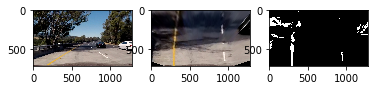

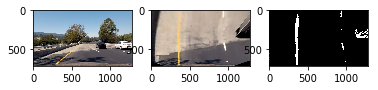

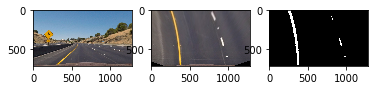

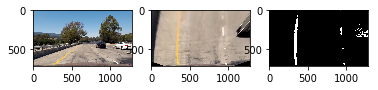

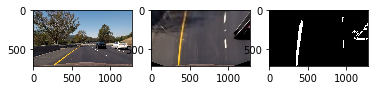

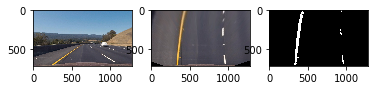

In [16]:
# 16
warp_images = []
warp_binary_images = []
# plot original color image, perspective transformed image, and perspective transformed binary image
for i in range(len(undist_images)):
    img = undist_images[i]
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, cv2.INTER_LINEAR)
    warp_images.append(warped)
    
    binary_img = thresh_images[i]
    warp_binary = cv2.warpPerspective(binary_img, M, img_size, cv2.INTER_LINEAR)
    warp_binary_images.append(warp_binary)
    
    fig = plt.figure()
    fig.add_subplot(1,3,1)
    plt.imshow(img)
    fig.add_subplot(1,3,2)
    plt.imshow(warped)
    fig.add_subplot(1,3,3)
    plt.imshow(warp_binary, cmap = 'gray')
    plt.show()

## 5. Detect Lane Pixels and Find the Lane Boundary

After applying calibration, thresholding, and a perspective transform to a road image, in the output binary image the lane lines stand out clearly. However, there are still noises in the pictures. Now we need to locate the lane lines  by deciding explicitly which pixels are part of the lines and which belong to the left line and which belong to the right line.

The idea is first finding the points belonging to the left and right lanes using histogram peaks, then do sliding window polynomial fitting to those identified points.

Here I simply borrow the functions of `finding_lane_pixels()` and `fit_polynomial()` from the lecture of "Implement Sliding Windows and Fit a Polynomial".

In [17]:
# 17
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 3) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy>= win_y_low) & (nonzeroy< win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy>= win_y_low) & (nonzeroy< win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # ().nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped, show_poly=False):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2) # y comes before x;  degree must be 2 because this is a 2D img
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    if show_poly:
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')

    return left_fit, right_fit, out_img

Simply test the above functions with a gray-scale warped lane line image obtained from the last section. As the below picture shows, the function recognizes the left and right lines successfully and plots a pile of green rectangles along each lane line.

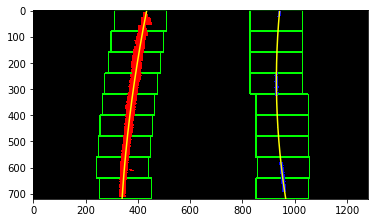

In [70]:
# 18
binary_warped = np.copy(warp_binary_images[5])
left_fit, right_fit, out_img = fit_polynomial(binary_warped, True)
plt.imshow(out_img)
plt.show()

Again, I simply reuse the codes from the lecture quiz here to do the least squares polynomial fit. When invoking the `fit_poly()` method in the pipeline, the parameters passed to this function are computed from `fit_polynomial()` function.

In [147]:
# 19
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit, show_poly=False):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    if show_poly:
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return left_fitx, right_fitx, result

## 6. Determine the Curvature of the Lane and Vehicle Offset.

The radius of the lane's curvature is computed in terms of the polynomial equations given in the lecture. So I reuse most of the codes I had done for the lecture quiz of "Measuring Curvature II". 

Because the original solution uses fake data representing lane-line pixels, I need to update the function to let it take actual data.

Meanwhile, the original solution returns only curvatures of the polynomial functions from the left and right lines.  I hereby add one more step to compute the average curvature of the left and right curvatures, because I want to display the average curvature finally.

In [96]:
# 20 
'''
Calculates the curvature of polynomial functions in meters (unit is radius)
'''
def measure_curvature(img_h, left_fit, right_fit):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Make sure to feed in your real data instead in your project!
    ploty = np.linspace(0, img_h-1, img_h)# to cover same y-range as image
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    avg_curverad = round(((left_curverad + right_curverad) / 2.), 3)
    return left_curverad, right_curverad, avg_curverad


To compute the offset, that is, the lane center from the center of the image, I refactor the codes used in the reference [2](https://zhuanlan.zhihu.com/p/35134563). The original author used one function `calculate_curv_and_pos()` to return both curvature and offset. I like the author's idea of computing offset because he finds both the offset values and the relative positions, left or right, between the car center and the lane center.

My changes are:
1. Re-organize the offset computing codes as a single function. I believe this improves the pipeline design because curvature and offset are two independent factors, there is not much correlation between these two values.
2. Remove hard-coded parameters in the original codes to make the function be more robust and adaptive to different image resolutions. 


In [97]:
# 21
'''
The offset of the lane center from the center of the image (converted from pixels to meters) 
is your distance from the center of the lane
Refactor the codes from https://github.com/yang1688899/CarND-Advanced-Lane-Lines/blob/master/utils.py
'''
def measure_offset(img_h, img_w, left_fit, right_fit):
    ploty = np.linspace(0, img_h-1, img_h)
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    lane_width = np.absolute(leftx[img_h-1] - rightx[img_h-1])
    lane_xm_per_pix = 3.7 / lane_width
    veh_pos = (((leftx[img_h-1] + rightx[img_h-1]) * lane_xm_per_pix) / 2.)
    cen_pos = ((img_w * lane_xm_per_pix) / 2.)# assume the camera is in the center of the car
    return round(cen_pos - veh_pos, 3)

## 7. Warp Detected Lane Boundaries Back To Image

As we already computed the line boundaries according to the warped image, we can apply the inverse matrix `Minv` to the warp image and project the detected lane boundaries back to the original undistorted image. 

The left lane is red, the right lane is blue, and the drivable region of the lane is highlighted with green color.

In [98]:
# 22
'''
Display boundaries of left and right lane-lines and highlight the lane with Green color
'''
def draw_area(undist, left_fit, right_fit):
    img_h = undist.shape[0]
    ploty = np.linspace(0, img_h-1, img_h)
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    
    color_warp = np.zeros_like(undist)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane and drivable region onto the warped blank image
    cv2.polylines(color_warp, np.int_(pts_left), isClosed=False, color=(255,0,0), thickness=80)
    cv2.polylines(color_warp, np.int_(pts_right), isClosed=False, color=(0,0,255), thickness=80)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

## 8. Output Visual Display of Lane Boundaries and Lane Curvature and Offset

Define a function to add annotations of the lane curvature and offset on the image.

In [99]:
# 23
'''
Put radius curvature and also the offset on an image
'''
def annotation(img, curvature, offset):
    radius_text = "Radius of Curvature: %sm"%(curvature)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    scale = 1
    white = (255, 255, 255)
    thickness = 2
    
    if offset>0:
        pos_flag = 'right'
    else:
        pos_flag= 'left'
        
    center_text = "Vehicle is %.3fm %s of center"%(abs(offset),pos_flag)
    cv2.putText(img, radius_text, (100,100), font, scale, white, thickness)
    cv2.putText(img, center_text, (100,150), font, scale, white, thickness)
    
    return img

# Construct a Pipeline

This section is most difficult part of the entire project (I spent many days here). In the final solution, in stead of using the `Line()` class structure suggested in the project guidelines, I re-use Huijing Huang's work [3]. The advantages of his work are: 1) It is easy to integrate the above mentioned methods into the Line class; 2) The sanity check is well defined along the class.

Since I already defined the most import functions above such as `search_around_poly()`, `fit_polynomial()`, `measure_curvature()`, `measure_offset()`, etc., I simply use those functions to replace Huang's original methods which functions the same. 

In [112]:
# 24
'''
Author: HUIJING HUANG
Email: dmsehuang@yahoo.com
Source Code: https://github.com/dmsehuang/CarND-Advanced-Lane-Lines/blob/project/Line.ipynb
'''
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.n = 8 # Number of iterations that's to be averaged
        
        self.img_w = None
        self.img_h = None
        
        # was the line detected in the last iteration?
        self.detected = False  
        
        #polynomial coefficients for the most recent fit
        self.curr_left_fit = [] 
        self.curr_right_fit = [] 
                                
        #polynomial coefficients averaged over the last n iterations
        self.best_left_fit = None  
        self.best_right_fit = None 
         
        #radius of curvature of the line in some units
        self.left_curvature = None
        self.right_curvature = None
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
    """
    Sanity check on new found lines.
    Input: left and right lane.
    Output: True or False means pass or not.
    """
    def sanity_check(self, left_fit, right_fit):
        ploty = np.linspace(0, self.img_h-1, self.img_h)
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
        
        # 1. Check if they have similar curvature
        curv_dev = 10 # variance, 5 times
        left_curverad, right_curverad, curverad = measure_curvature(self.img_h, left_fit, right_fit) 
        
        ratio = left_curverad / right_curverad 
        if ((ratio >= curv_dev) | (ratio <= 1./curv_dev)):
            return False
        
        # 2. Check lines are seperated by right distance
        dist_dev = 100
        valid_dist = 850 # Lane line pixel is about 830 wide, stay tuned
        curr_dist = right_fitx[-1] - left_fitx[-1]
        #print("curr dist", curr_dist)
        if (np.abs(curr_dist - valid_dist) > dist_dev):
            return False
        
        # 3. Check if lines are roughly paralell
        lines_dev = 80
        dist = right_fitx - left_fitx
        dev = np.std(dist)
        #print("std dev", dev)
        if (dev >= lines_dev):
            return False
            
        return True
        
    """
    Find lane pixels given a binary warped image.
    Input: a binary image from birds' eye view.
    Output: left and right lane in polynomial function and a diagnosis image
    """
    def find_lane(self, binary_warped):
        self.img_w = binary_warped.shape[1]
        self.img_h = binary_warped.shape[0]
        
        if (self.detected) and (len(self.curr_left_fit)>0 and len(self.curr_right_fit) >0):
            last_left_fit = self.curr_left_fit[-1]
            last_right_fit = self.curr_right_fit[-1]
            left_fit, right_fit, diag_img = search_around_poly(binary_warped, last_left_fit, last_right_fit)
        else:
            left_fit, right_fit, diag_img = fit_polynomial(binary_warped)
        
        if (self.sanity_check(left_fit, right_fit)):
            self.detected = True
        else:
            self.detected = False
            # use the last one as current fit
            if (len(self.curr_left_fit)>0 and len(self.curr_right_fit) >0):
                left_fit = self.curr_left_fit[-1]
                right_fit = self.curr_right_fit[-1]
        
        self.curr_left_fit.append(left_fit)
        self.curr_right_fit.append(right_fit)
        
        # Only keep last n iterations
        if (len(self.curr_left_fit) > self.n):
            self.curr_left_fit = self.curr_left_fit[-self.n:]
            self.curr_right_fit = self.curr_right_fit[-self.n:]
        
        # average
        self.best_left_fit = np.mean(self.curr_left_fit, axis=0)
        self.best_right_fit = np.mean(self.curr_right_fit, axis=0)
        
        # Calculate curvature and offset
        self.left_curvature, self.right_curvature, self.radius_of_curvature = measure_curvature(self.img_h, left_fit, right_fit)
        self.line_base_pos = measure_offset(self.img_h, self.img_w, left_fit, right_fit)
        return diag_img
    
    def get_lane(self):
        return self.best_left_fit, self.best_right_fit
    
    def get_curvature(self):
        return self.left_curvature, self.right_curvature, self.radius_of_curvature
    
    def get_offset(self):
        return self.line_base_pos

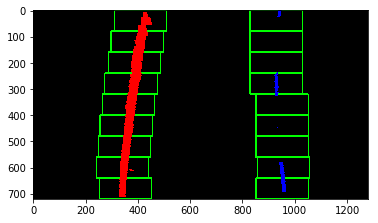

[  9.31011957e-05  -1.97581813e-01   4.33799925e+02] [  1.73393505e-04  -9.22706396e-02   9.42074703e+02]
1764.13216542 947.697195752 1355.915
-0.075


In [113]:
# 25
img = warp_binary_images[5]
line = Line()

diag_img = line.find_lane(img)
left_fit, right_fit = line.get_lane()
left_curv, right_curv, curv = line.get_curvature()
offset = line.get_offset()

plt.imshow(diag_img)
plt.show()
print(left_fit, right_fit)
print(left_curv, right_curv, curv)
print(offset)

In [114]:
# 26
line = Line()

def pipeline(img):
    # undistortion correction
    undist_img = cv2.undistort(img, cam_mtx, cam_dist, None, cam_mtx)
    #thresholded binary image
    thresholded_img = hls_gradient_thresh(undist_img)
    #perspective transform
    warp_img = cv2.warpPerspective(thresholded_img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    #line detection
    diag_img = line.find_lane(warp_img)
    left_fit, right_fit = line.get_lane()
    left_curv, right_cur, avg_curv = line.get_curvature()
    offset = line.get_offset()
    #draw the detected laneline and the information
    area_img = draw_area(undist_img, left_fit, right_fit)
    out_img = annotation(area_img, avg_curv, offset)
    return out_img

Test the entire pipeline with a color image:

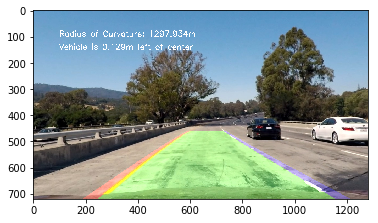

In [115]:
# 27

test_img = mpimg.imread('./test_images/test1.jpg')
out_img = pipeline(test_img)
plt.imshow(out_img)
plt.show()

## Video Test

The pipeline gives good result image so we can apply the pipeline to process the image stream.

In [116]:
# 28
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
line = Line()

white_output = 'project_video_out_clip_2.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_out_clip_2.mp4
[MoviePy] Writing video project_video_out_clip_2.mp4


 99%|█████████▉| 125/126 [01:12<00:00,  1.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out_clip_2.mp4 

CPU times: user 54.8 s, sys: 7.55 s, total: 1min 2s
Wall time: 1min 15s


In [118]:
# 29
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [48]:
# 30
project_outpath = 'project_video_out_full.mp4'
project_video_clip = VideoFileClip("project_video.mp4")
project_video_out_clip = project_video_clip.fl_image(pipeline)
project_video_out_clip.write_videofile(project_outpath, audio=False)

[MoviePy] >>>> Building video project_video_out_full.mp4
[MoviePy] Writing video project_video_out_full.mp4


100%|█████████▉| 1260/1261 [12:48<00:00,  1.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out_full.mp4 



In [50]:
# 31
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_out_clip))

## Test Challenge Video 

As the project video is successfully processed by the pipeline above, now test the pipeline with the challenge video.
The result show that current pipeline can not handle the challenge video successfully. There are two main problems not solved:
1. The polynomial fit does not work correctly when the road ahead (inside the region of interest) has more than one curves, such as an "S"-like road.
1. The curvature is not computed correctly.

In [52]:
# 32
challenge_outpath = 'challenge_video_out_clip.mp4'
challenge_video_clip = VideoFileClip("harder_challenge_video.mp4").subclip(0,5)
challenge_video_out_clip = challenge_video_clip.fl_image(pipeline)
challenge_video_out_clip.write_videofile(challenge_outpath, audio=False)

[MoviePy] >>>> Building video challenge_video_out_clip.mp4
[MoviePy] Writing video challenge_video_out_clip.mp4



 99%|█████████▉| 125/126 [01:17<00:00,  1.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_out_clip.mp4 



In [54]:
# 33
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_video_out_clip))

## References

1. [CIELAB color space wikipedia](https://en.wikipedia.org/wiki/CIELAB_color_space)
2. [Lane Finding (车道线检测)](https://zhuanlan.zhihu.com/p/35134563)
3. [Huijing Huang' Github](https://github.com/dmsehuang/CarND-Advanced-Lane-Lines)